<a href="https://colab.research.google.com/github/nandinib1999/handwritten-text-recognition/blob/main/Handwritten_Text_Recognition_IAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir "dataset"

In [ ]:
import numpy as np
import random
from tensorflow.keras import backend as K
from tqdm import tqdm

In [ ]:
import tarfile
tf = tarfile.open("/content/drive/MyDrive/words.tar")
tf.extractall("/content/dataset")

In [ ]:
data_dir = "/content/dataset"

In [ ]:
def parse_image_paths_and_texts(input_file_path):
  image_path_text = []
  max_length = 0
  with open(input_file_path, 'r') as fhead:
    lst = fhead.readlines()
  counter = 0
  for line in lst:
    line = line.strip()
    line_split = line.split(" ")
    if not line_split[-1].isalnum() and len(line_split[-1]) == 1:
      counter = counter + 1
      pass
    else:
      if line_split[1] == 'ok':
        directory_split = line_split[0].split('-')      
        image_location = f'{data_dir}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{line_split[0]}.png'
        if image_location != "/content/dataset/a01/a01-117/a01-117-05-02.png" and image_location != "/content/dataset/r06/r06-022/r06-022-03-05.png":
          gt_text = line_split[-1]
          if len(gt_text) > max_length:
            max_length = len(gt_text)
          if len(gt_text) > 16:
            continue
          image_path_text.append([image_location, gt_text])
  return image_path_text, max_length

In [ ]:
image_path_text, length = parse_image_paths_and_texts("/content/parser.txt")
print(len(image_path_text))
print(length)

85074
21


In [ ]:
from sklearn.model_selection import train_test_split

train_val_list, test_list = train_test_split(image_path_text[:10000], test_size=0.1, random_state=47)

In [ ]:
train_list, val_list = train_test_split(train_val_list, test_size=0.1, random_state=47)
print(len(train_list))
print(len(val_list))
print(len(test_list))

8100
900
1000


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h-old_h)/2), int((new_h-old_h)/2)+old_h
    w1, w2 = int((new_w-old_w)/2), int((new_w-old_w)/2)+old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2,:] = img
    return img_pad

def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w<target_w and h<target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w>=target_w and h<target_h:
        new_w = target_w
        new_h = int(h*new_w/w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w<target_w and h>=target_h:
        new_h = target_h
        new_w = int(w*new_h/h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        '''w>=target_w and h>=target_h '''
        ratio = max(w/target_w, h/target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img

def preprocess(path, img_w, img_h):
    img = cv2.imread(path)
    if img is not None:
      img = fix_size(img, img_w, img_h)

      img = np.clip(img, 0, 255)
      img = np.uint8(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
      img = img.astype(np.float32)
      img /= 255
    else:
      print("IMAGE ERROR::: SKIPPPEDDDD ... ", path)
    return img

/content/dataset/a04/a04-085/a04-085-05-02.png
(94, 297, 3)


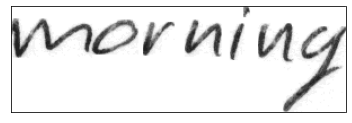

In [ ]:
print(train_list[0][0])
img = cv2.imread(train_list[0][0])
print(img.shape)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

(32, 128)


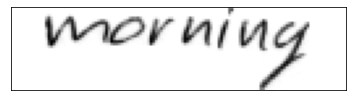

In [ ]:
img = preprocess(train_list[0][0], 128, 32)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
BATCH_SIZE = 64
INPUT_LENGTH = 30
MAX_TEXT_LEN = 16
IMG_W = 128
IMG_H = 32

In [ ]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


In [ ]:
def text_to_labels(text):
    labels = []
    for char in text:
      labels.append(letters.index(char))
    return labels

def labels_to_text(labels):
    text = []
    for indx in labels:
      text.append(letters[int(indx)])
    return "".join(text)

In [ ]:
text_to_labels(train_list[0][1])

[65, 67, 70, 66, 61, 66, 59]

In [ ]:
labels_to_text([60, 53, 64, 58])

'half'

In [ ]:
class IAMDataGenerator:
    def __init__(self, image_text, batch_size, input_length, max_text_len, img_width, img_height):
        self.samples = image_text
        self.n_samples = len(self.samples)
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.input_length = input_length
        self.indices = list(range(self.n_samples))
        self.index_current = 0
        
    def get_data(self):
        self.img_ls = np.zeros((self.n_samples, self.img_height, self.img_width))
        self.text_ls = []
        for i, (img_file_path, text) in tqdm(enumerate(self.samples), total=self.n_samples):
            img = preprocess(img_file_path, self.img_width, self.img_height)
            if img is not None:
              self.img_ls[i, :, :] = img
              self.text_ls.append(text)
    
    def get_next_sample(self):
        self.index_current += 1
        if self.index_current >= self.n_samples:
            self.index_current = 0
            random.shuffle(self.indices)
        return self.img_ls[self.indices[self.index_current]], self.text_ls[self.indices[self.index_current]]
    
    def next_batch(self):
      while True:
          # width and height are backwards from typical Keras convention
          # because width is the time dimension when it gets fed into the RNN
          X_data = np.ones([self.batch_size, self.img_width, self.img_height, 1])
          Y_data = np.zeros([self.batch_size, self.max_text_len])
          input_length = np.ones((self.batch_size, 1)) * self.input_length
          label_length = np.zeros((self.batch_size, 1))
                                  
          for i in range(self.batch_size):
              img, text = self.get_next_sample()
              img = img.T
              img = np.expand_dims(img, -1)
              X_data[i] = img
              Y_data[i, :len(text)] = text_to_labels(text)
              label_length[i] = len(text)
              
          inputs = [X_data, Y_data, input_length, label_length]
          outputs = np.zeros([self.batch_size])
          yield (inputs, outputs)

In [ ]:
train_generator = IAMDataGenerator(train_list, 8, INPUT_LENGTH, MAX_TEXT_LEN, IMG_W, IMG_H)
validation_generator = IAMDataGenerator(val_list, 8, INPUT_LENGTH, MAX_TEXT_LEN, IMG_W, IMG_H)

In [ ]:
train_generator.get_data()
print(train_generator.img_ls.shape)

100%|██████████| 8100/8100 [00:07<00:00, 1146.85it/s]

(8100, 32, 128)


In [ ]:
validation_generator.get_data()
print(validation_generator.img_ls.shape)

100%|██████████| 900/900 [00:00<00:00, 1189.80it/s]

(900, 32, 128)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Reshape, Lambda, BatchNormalization, Conv2D, MaxPooling2D, GRU, add, concatenate
from tensorflow.keras import Model, layers
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def word_model():
    if K.image_data_format() == 'channels_first':
        input_shape = (1, IMG_W, IMG_H)
    else:
        input_shape = (IMG_W, IMG_H, 1)

    input_data = layers.Input(name='the_input', shape=(128, 32, 1), dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
    iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)

    iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

    iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)

    iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)
    iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

    iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
    iam_layers = layers.BatchNormalization()(iam_layers)
    iam_layers = layers.Activation('relu')(iam_layers)

    # CNN to RNN
    iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
    iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

    # RNN layer
    gru_1 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru1')(iam_layers)
    gru_1b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(iam_layers)
    reversed_gru_1b = layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (gru_1b)

    gru1_merged = layers.add([gru_1, reversed_gru_1b])
    gru1_merged = layers.BatchNormalization()(gru1_merged)

    gru_2 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    reversed_gru_2b= layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (gru_2b)

    gru2_merged = layers.concatenate([gru_2, reversed_gru_2b])
    gru2_merged = layers.BatchNormalization()(gru2_merged)

    # transforms RNN output to character activations:
    iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(gru2_merged)
    iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

    labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


    # loss function
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    act_model = Model(input_data, iam_outputs)
    model.summary()
    act_model.summary()

    return model, act_model

In [ ]:
model_train, model_pred = word_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64, 64)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model_train.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [ ]:
import time
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time )
        # cur_epoch_time = datetime.strptime(str(cur_epoch_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))
    
    ## functions used below are for recording validation times
    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        # cur_test_time = datetime.strptime(str(cur_test_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        print(" ;validation took {0} minutes.".format(cur_test_time))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath='/content/gru-weights-epoch{epoch:02d}-val_loss{val_loss:.3f}.h5', verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
epoch_times = EpochTimeHistory()

In [ ]:
history_model = model_train.fit(train_generator.next_batch(),
                            validation_data=validation_generator.next_batch(),
                            steps_per_epoch=train_generator.n_samples/BATCH_SIZE,
                            validation_steps=validation_generator.n_samples // BATCH_SIZE,
                            epochs=30, verbose=1,
                            callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/30
126/126 [==============================] - 78s 305ms/step - loss: 23.2848 - val_loss: 49.9939

Epoch 00001: val_loss improved from inf to 49.99393, saving model to /content/gru-weights-epoch01-val_loss49.994.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


 ;epoch 1 took 1.3021 minutes.
Epoch 2/30
126/126 [==============================] - 37s 292ms/step - loss: 14.0028 - val_loss: 33.2095

Epoch 00002: val_loss improved from 49.99393 to 33.20953, saving model to /content/gru-weights-epoch02-val_loss33.210.h5
 ;epoch 2 took 0.6203 minutes.
Epoch 3/30
126/126 [==============================] - 37s 293ms/step - loss: 11.9355 - val_loss: 16.8904

Epoch 00003: val_loss improved from 33.20953 to 16.89037, saving model to /content/gru-weights-epoch03-val_loss16.890.h5
 ;epoch 3 took 0.622 minutes.
Epoch 4/30
126/126 [==============================] - 37s 293ms/step - loss: 10.3683 - val_loss: 12.5850

Epoch 00004: val_loss improved from 16.89037 to 12.58498, saving model to /content/gru-weights-epoch04-val_loss12.585.h5
 ;epoch 4 took 0.6234 minutes.
Epoch 5/30
126/126 [==============================] - 37s 292ms/step - loss: 9.0509 - val_loss: 10.3625

Epoch 00005: val_loss improved from 12.58498 to 10.36251, saving model to /content/gru-weig

In [ ]:
import itertools

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], 1))
    out_best = [k for k, g in itertools.groupby(out_best)]
    outstr = ''
    for c in out_best:
        if c < len(letters):
            outstr += letters[c]
    return outstr

def predict_image(model_predict, path):
    img = preprocess(path, 128, 64)
    img = img.T
    if K.image_data_format() == 'channels_first':
        img = np.expand_dims(img, 0)
    else:
        img = np.expand_dims(img, -1)
    img = np.expand_dims(img, 0)

    net_out_value = model_predict.predict(img)
    pred_texts = decode_label(net_out_value)
    return pred_texts

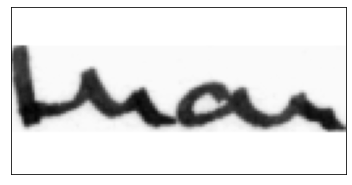

Original: than
Predicted: than



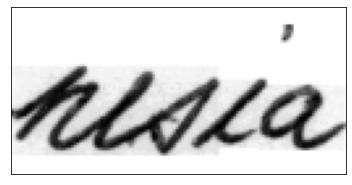

Original: nesia
Predicted: saia



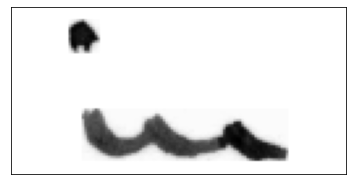

Original: in
Predicted: in



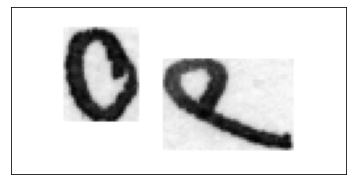

Original: be
Predicted: be



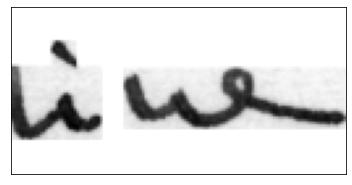

Original: like
Predicted: lie



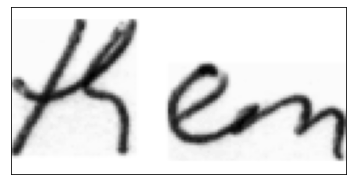

Original: them
Predicted: then



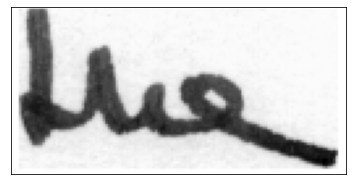

Original: the
Predicted: the



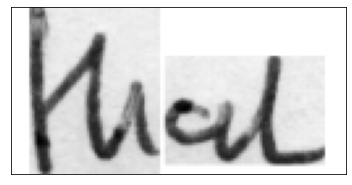

Original: that
Predicted: that



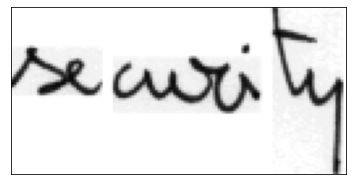

Original: security
Predicted: searity



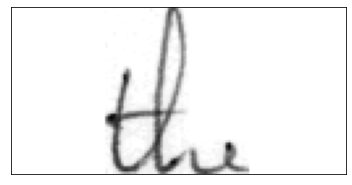

Original: the
Predicted: te



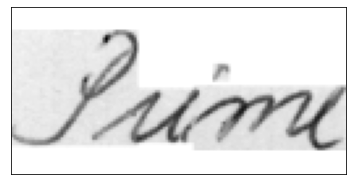

Original: Prime
Predicted: Aiim



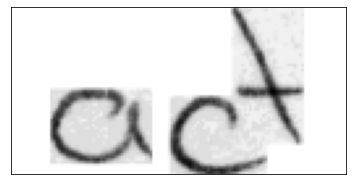

Original: act
Predicted: aat



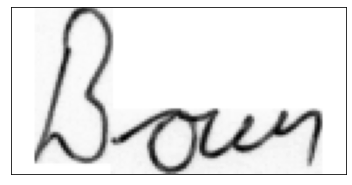

Original: Boun
Predicted: Brun



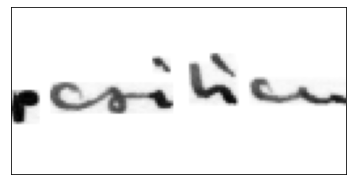

Original: position
Predicted: poition



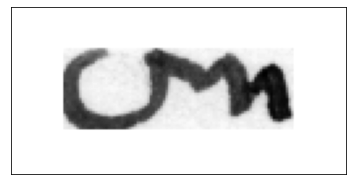

Original: on
Predicted: on



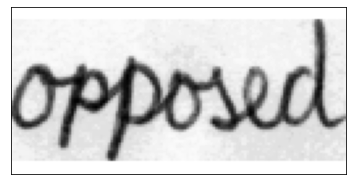

Original: opposed
Predicted: oppsed



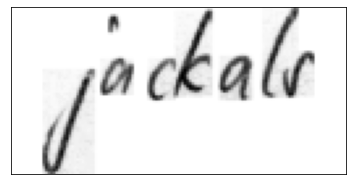

Original: jackals
Predicted: jaals



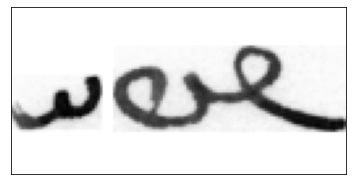

Original: were
Predicted: vere



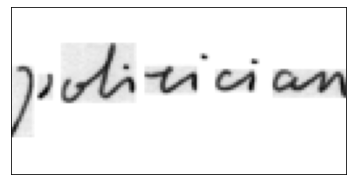

Original: politician
Predicted: podiaian



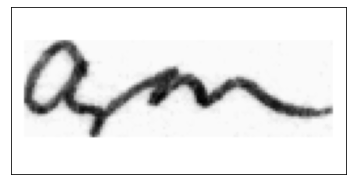

Original: arm
Predicted: an



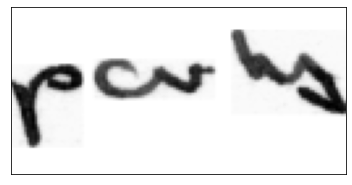

Original: party
Predicted: party



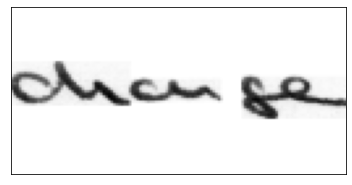

Original: change
Predicted: dauge



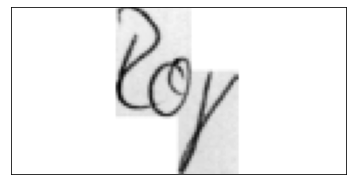

Original: Roy
Predicted: oop



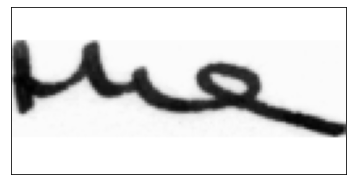

Original: the
Predicted: the



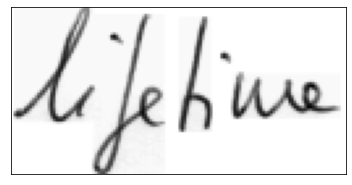

Original: lifetime
Predicted: liftinme



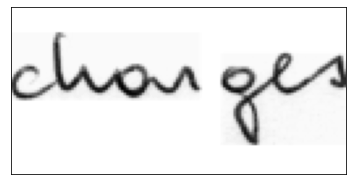

Original: charges
Predicted: chages



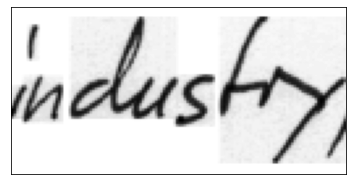

Original: industry
Predicted: industy



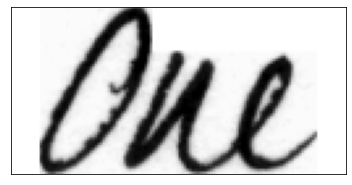

Original: One
Predicted: be



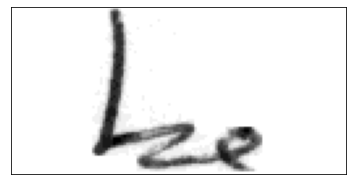

Original: be
Predicted: as



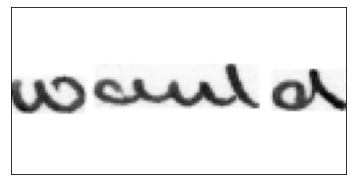

Original: would
Predicted: would



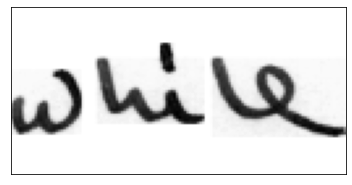

Original: while
Predicted: whle



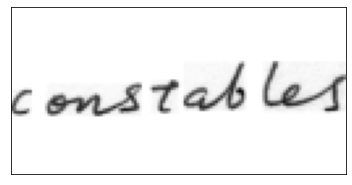

Original: constables
Predicted: cousales



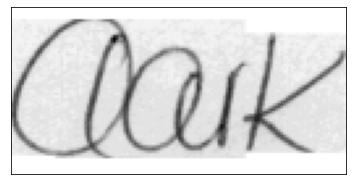

Original: Clark
Predicted: Olrl



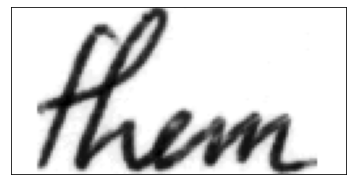

Original: them
Predicted: them



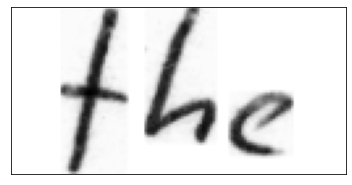

Original: the
Predicted: thhe



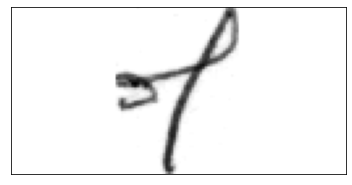

Original: of
Predicted: of



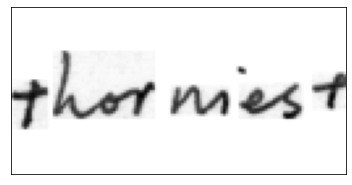

Original: thorniest
Predicted: slosminst



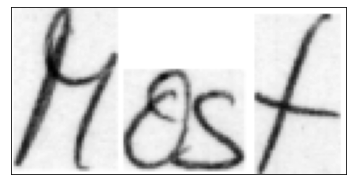

Original: Most
Predicted: flst



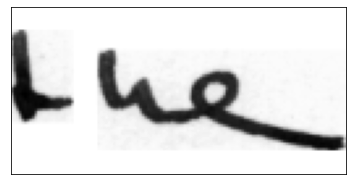

Original: the
Predicted: the



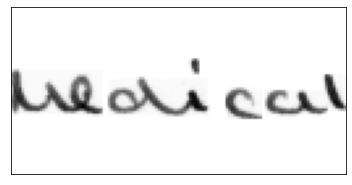

Original: Medical
Predicted: Wedial



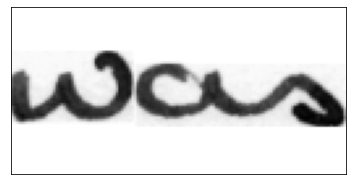

Original: was
Predicted: was



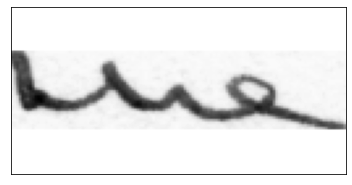

Original: the
Predicted: the



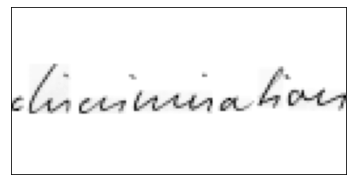

Original: discrimination
Predicted: diciiiiaton



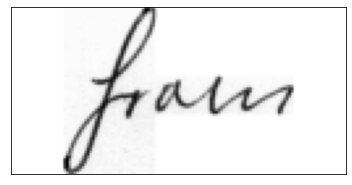

Original: from
Predicted: foum



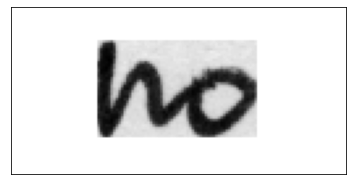

Original: no
Predicted: no



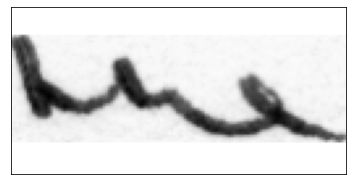

Original: the
Predicted: the



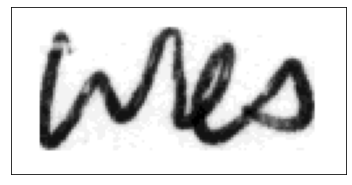

Original: was
Predicted: wvas



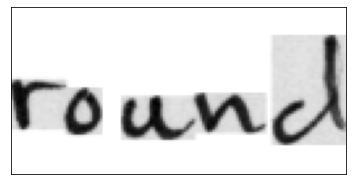

Original: round
Predicted: round



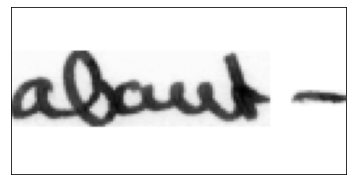

Original: about-
Predicted: abut-



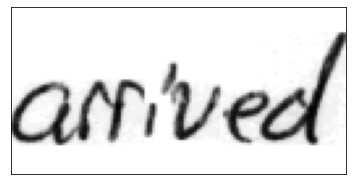

Original: arrived
Predicted: arrted



In [ ]:
model_pred.load_weights("/content/gru-weights-epoch21-val_loss6.008.h5")
for indx in range(len(val_list[:50])):
  image_path = val_list[indx][0]
  predicted_text = predict_image(model_pred, image_path)
  plt.imshow(preprocess(val_list[indx][0], 128, 64), cmap=plt.cm.gray)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print("Original:", val_list[indx][1])
  print("Predicted:", predicted_text)
  print()